In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import math
from collections import namedtuple
from functools import partial
np.seterr(all='raise')
pass

In [2]:
data = pd.read_csv("non-parametric.csv", sep=";", index_col="id")
X = data.values[:, 0]
Y = data.values[:, 1]
plot_x = np.linspace(np.min(X), np.max(X), 100)

## Формула Надарая–Ватсона

$$
\large
a_h(x; X^l) = \frac{\sum\limits_{i=1}^l y_i K\left(\frac{\rho(x, x_i)}{h}\right)}{\sum\limits_{i=1}^l K\left(\frac{\rho(x, x_i)}{h}\right)}
$$

In [3]:
def kernelConst(x):
    return (np.abs(x) < 1.0) * 0.5

def kernelTriangle(x):
    xabs = np.abs(x)
    return (xabs < 1.0) * (1.0 - xabs)

def kernelEpanechnikov(x):
    return 0.75 * (1.0 - x ** 2.0) * (np.abs(x) < 1.0)


class nwClassifier():
    def __init__(self, h, kernel):
        self.h = h
        self.kernel = kernel

    def fit(self, x, y):
        self.x = x
        self.y = y
        
    def calc_kernels(self, point):
        return self.kernel(np.abs(self.x - point) / self.h)

    def predict(self, point):
        kernels = self.calc_kernels(point)
        return np.sum(self.y * kernels) / np.sum(kernels)

    def __str__(self):
        return "{} with h={} and kernelFunction={}".format(type(self).__name__, str(self.h), self.kernel.__name__)

In [4]:
def plot_classifier(classifier, plot_x):
    plot_y = np.vectorize(classifier.predict)(plot_x)
    plt.plot(plot_x, plot_y, label=str(classifier))

In [5]:
classifier1 = nwClassifier(1.5, kernelConst)
classifier2 = nwClassifier(3,   kernelTriangle)
classifier3 = nwClassifier(4.5, kernelEpanechnikov)
classifier1.fit(X, Y)
classifier2.fit(X, Y)
classifier3.fit(X, Y)

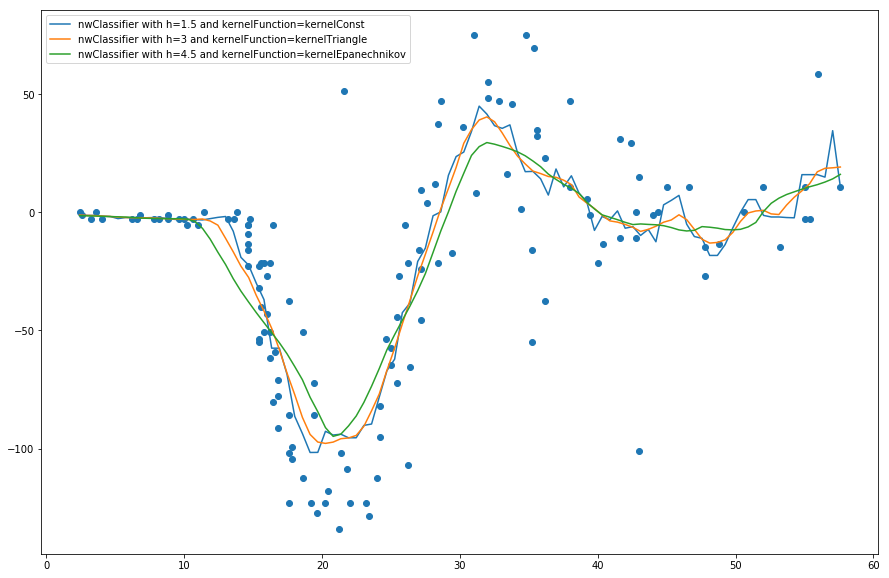

In [6]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(X, Y)
plot_classifier(classifier1, plot_x)
plot_classifier(classifier2, plot_x)
plot_classifier(classifier3, plot_x)
plt.legend()
plt.show()

## LOWESS

In [7]:
class lowessClassifier(nwClassifier):
    EPS = 0.1
    
    def calc_gamma(self):
        self.gamma = np.ones_like(self.x)
        aaa = np.zeros_like(self.x)
        errors = np.zeros_like(self.x)
        while (True):
            for i, x in enumerate(self.x):
                kernels = self.calc_kernels(x)
                kernels[i] = 0
                aaa[i] = np.sum(self.y * kernels) / np.sum(kernels)
            errors = np.abs(aaa - self.y)
            med6 = 6 * np.median(errors)
            new_gamma = self.kernel(errors / med6)
            norm = np.linalg.norm(new_gamma - self.gamma)
            self.gamma = new_gamma
            if (norm < self.EPS):
                break
            
    def fit(self, x, y):
        nwClassifier.fit(self, x, y)
        self.calc_gamma()
        
    def calc_kernels(self, point):
        return self.gamma * nwClassifier.calc_kernels(self, point)

In [8]:
classifier1 = lowessClassifier(2,   kernelConst)
classifier2 = lowessClassifier(3.5, kernelTriangle)
classifier3 = lowessClassifier(5,   kernelEpanechnikov)
classifier4 = lowessClassifier(2,   kernelEpanechnikov)
classifier1.fit(X, Y)
classifier2.fit(X, Y)
classifier3.fit(X, Y)
classifier4.fit(X, Y)

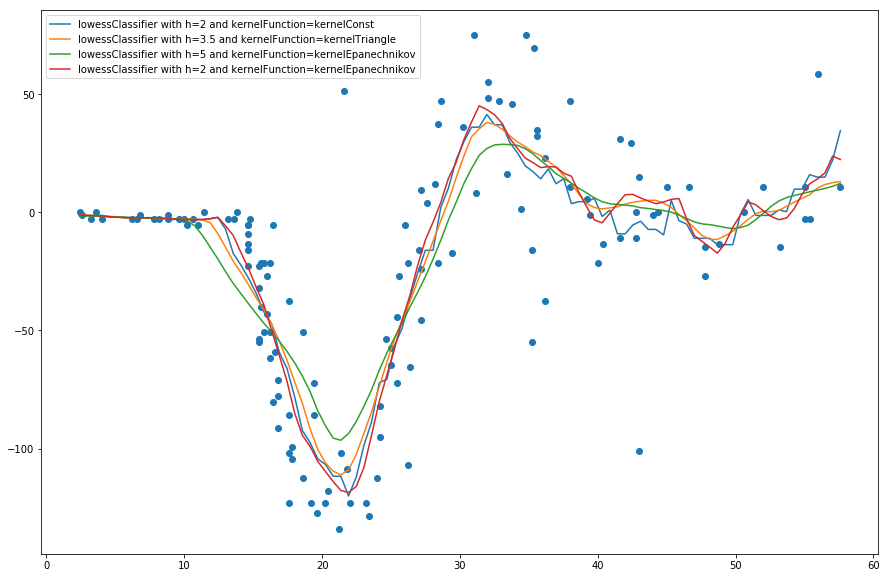

In [9]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(X, Y)
plot_classifier(classifier1, plot_x)
plot_classifier(classifier2, plot_x)
plot_classifier(classifier3, plot_x)
plot_classifier(classifier4, plot_x)
plt.legend()
plt.show()

## Сглаживание B-сплайнами

In [10]:
class SplineClassifier:
    
    T = 10
    
    def fit(self, X, Y):
        self.a0, self.a1, self.a2, self.a3 = [], [], [], []
        self.b0, self.b1, self.b2, self.b3 = [], [], [], []
        self.X = X
        
        for i in range(len(X) - 1):
            im1 = i - 1 if i > 0 else 0
            i1  = i + 1
            i2  = i + 2 if i + 2 < len(X) else i + 1 
            
            self.a0.append((X[im1] + 4 * X[i]+ X[i1]) / 6)
            self.a1.append((-X[im1] + X[i1]) / 2)
            self.a2.append((X[im1] - 2 * X[i] + X[i1]) / 2)
            self.a3.append((-X[im1] + 3 * X[i] - 3 * X[i1] + X[i2]) / 6)
            
            self.b0.append((Y[im1] + 4 * Y[i]+ Y[i1]) / 6)
            self.b1.append((-Y[im1] + Y[i1]) / 2)
            self.b2.append((Y[im1] - 2 * Y[i] + Y[i1]) / 2)
            self.b3.append((-Y[im1] + 3 * Y[i] - 3 * Y[i1] + Y[i2]) / 6) 
        
    def predict(self, x):
        if (x < self.X[0] or x > self.X[len(self.X) - 1]): 
            raise "illegal argument"
        
        for i in range(len(self.X) - 1):
            if (x <= self.X[i + 1]):
                break

        min_t = None
        min_x_dist = None
        for t in range(self.T + 1):
            t /= self.T
            
            x_pred = ((self.a3[i] * t + self.a2[i]) * t + self.a1[i]) *t + self.a0[i]
            x_dist = abs(x - x_pred)
            if (min_x_dist is None or x_dist < min_x_dist):
                min_x_dist = x_dist
                min_t = t
            
        return ((self.b3[i] * min_t + self.b2[i]) * min_t + self.b1[i]) * min_t + self.b0[i]

In [11]:
splineClassifier = SplineClassifier()
splineClassifier.fit(X, Y)

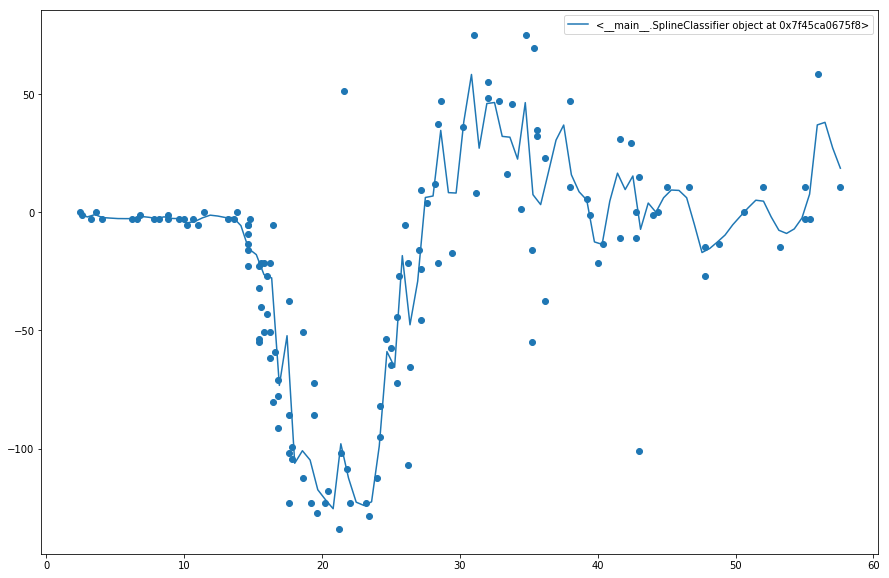

In [12]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(X, Y)
plot_classifier(splineClassifier, plot_x)
plt.legend()
plt.show()

## Оценка алгоритмов

In [13]:
def rmse(X, Y, classifier):
    classifier.fit(X, Y)
    predict_vect = np.vectorize(lambda x : classifier.predict(x))
    Y_pred = predict_vect(X)
    return np.sqrt(np.sum((Y - Y_pred) ** 2) / len(Y))

def rmse_loo(X, Y, classifier):
    mse = 0
    for i in range(len(X)):
        X_1 = np.delete(X, i)
        Y_1 = np.delete(Y, i)
        
        classifier.fit(X_1, Y_1)
        y_pred = classifier.predict(X[i])
        
        mse += (Y[i] - y_pred) ** 2
    return math.sqrt(mse)

In [14]:
print(rmse(X, Y, classifier1))
print(rmse(X, Y, classifier2))
print(rmse(X, Y, classifier3))
print(rmse(X, Y, classifier4))
print(rmse(X, Y, splineClassifier))

28.4523360215
28.6814453408
30.5152124064
27.6583840623
20.0119298618
